In [6]:
!pip install --upgrade pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp36-none-any.whl size=18178 sha256=55ec69a50d62b490b3ebad643339ec2ba3340f9efc17a1b05cc33f60681fa8f9
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE


In [23]:
import jax.numpy as np   
from jax import grad, jacfwd, jit, random, vmap
from jax.scipy.stats import norm
from pyDOE import lhs
import matplotlib.pyplot as plt

In [8]:
class BayesianLinearRegression:
  """
    Linear regression model: y = (w.T)*x + \epsilon
    w ~ N(0,beta^(-1)I)
    P(y|x,w) ~ N(y|(w.T)*x,alpha^(-1)I)
  """
  def __init__(self, X, y, alpha = 1.0, beta = 1.0):
      # Store training data
      self.X = X
      self.y = y
      # Store precisions
      self.alpha = alpha
      self.beta = beta
      # Small jitter for numerically stable matrix inversion
      self.jitter = 1e-8

  # Computes the MLE estimate of the regression weights
  def fit_MLE(self):
      xTx_inv = np.linalg.inv(np.matmul(self.X.T,self.X) + self.jitter)
      xTy = np.matmul(self.X.T, self.y)
      w_MLE = np.matmul(xTx_inv, xTy)
      self.w_MLE = w_MLE
      return w_MLE

  # Computes the MAP estimate of the regression weights
  def fit_MAP(self):
      Lambda = np.matmul(self.X.T,self.X) + \
               (self.beta/self.alpha)*np.eye(self.X.shape[1])
      Lambda_inv = np.linalg.inv(Lambda)
      xTy = np.matmul(self.X.T, self.y)
      mu = np.matmul(Lambda_inv, xTy)
      self.w_MAP = mu
      self.Lambda_inv = Lambda_inv
      return mu, Lambda_inv

  # Computes the predictive posterior distribution
  def predictive_distribution(self, X_star):
      mean_star = np.matmul(X_star, self.w_MAP)
      var_star = np.eye(X_star.shape[0])/self.alpha + \
                 np.matmul(X_star, np.matmul(self.Lambda_inv, X_star.T))
      return mean_star, var_star


In [9]:
# N is the number of training points.
N = 5
noise_var = 0.3
alpha = 1.0/noise_var
beta = 0.2

In [10]:
# Create random input and output data
key = random.PRNGKey(0)
X = lhs(1, N)
y = 5*X
y = y + noise_var*random.normal(key, y.shape)

In [11]:
# Define model
m = BayesianLinearRegression(X, y, alpha, beta)

In [12]:
# Fit MLE and MAP estimates for w
w_MLE = m.fit_MLE()
w_MAP, Lambda_inv = m.fit_MAP()

In [13]:
# Predict at a set of test points
X_star = np.linspace(0,1,200)[:,None]
y_pred_MLE = np.matmul(X_star, w_MLE)
y_pred_MAP = np.matmul(X_star, w_MAP)

In [19]:
# Draw sampes from the predictive posterior
num_samples = 500
mean_star, var_star = m.predictive_distribution(X_star)
samples = random.multivariate_normal(key, mean_star.flatten(), var_star, (num_samples,))


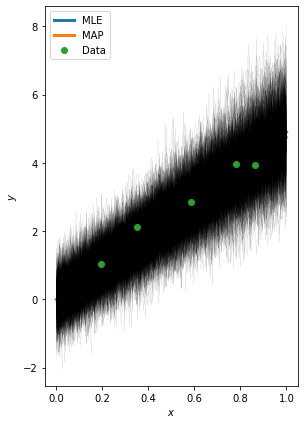

In [21]:
# Plot
plt.figure(1, figsize=(8,6))
plt.subplot(1,2,1)
plt.plot(X_star, y_pred_MLE, linewidth=3.0, label = 'MLE')
plt.plot(X_star, y_pred_MAP, linewidth=3.0, label = 'MAP')
for i in range(0, num_samples):
    plt.plot(X_star, samples[i,:], 'k', linewidth=0.05)
plt.plot(X,y,'o', label = 'Data')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()

(-0.5, 10.5, -0.03827770948410034, 0.8038318991661072)

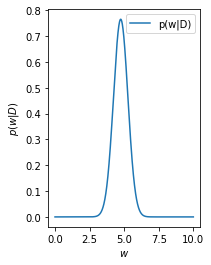

In [24]:
# Plot distribution of w
plt.subplot(1,2,2)
x_axis = np.linspace(0, 10, 1000)[:,None]
plt.plot(x_axis, norm.pdf(x_axis,w_MAP,Lambda_inv), label = 'p(w|D)')
plt.legend()
plt.xlabel('$w$')
plt.ylabel('$p(w|D)$')
plt.axis('tight')